# 4.0 Data and Feature Validation (Trial 2)

### Required Modules

In [71]:
# Basic Operations
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Data Set Up

In [72]:
# Reconstructed Data with Raw Features (99)
aug_data = pd.read_csv("data/training-set-1/pose_data_augmented_res.csv")
Xr = aug_data.iloc[:,5:104]
yr = aug_data['label_encoded'].values

# Reconstructed Data with Added Features (123)
Xa = aug_data.iloc[:,5:134]
ya = aug_data['label_encoded'].values

poses_names = aug_data['label'].values

#Scaled
scaler = StandardScaler()
Xr_scaled = scaler.fit_transform(Xr)
Xa_scaled = scaler.fit_transform(Xa)

## 4.1 Cross Validation of Data Augmentation

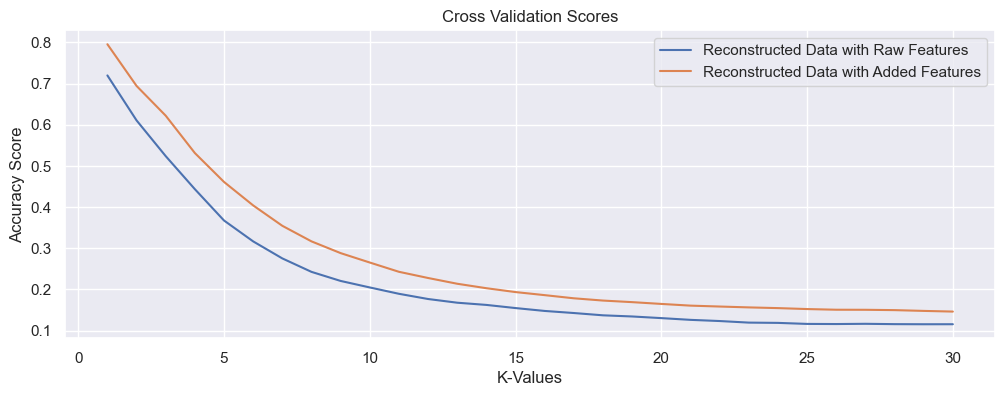

In [21]:
k_values = [i for i in range(1, 31)]

scores_Xr = []
scores_Xa = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xr_scaled, yr)
    score_Xr = cross_val_score(knn, Xr_scaled, yr, cv=10, scoring='accuracy')
    scores_Xr.append(np.mean(score_Xr))
    knn.fit(Xa_scaled, ya)
    score_Xa = cross_val_score(knn, Xa_scaled, ya, cv=10, scoring='accuracy')
    scores_Xa.append(np.mean(score_Xa))

sns.set(rc={'figure.figsize':(12,4)})
sns.lineplot(x = k_values, y = scores_Xr, label='Reconstructed Data with Raw Features')
sns.lineplot(x = k_values, y = scores_Xa, label='Reconstructed Data with Added Features')
plt.title("Cross Validation Scores")
plt.xlabel('K-Values')
plt.ylabel('Accuracy Score')
plt.show()

In [23]:
# Find index of maximum accuracy for reconstructed data 
idx_max_Xr = np.argmax(scores_Xr)
optimal_k_Xr = k_values[idx_max_Xr]
max_accuracy_Xr = scores_Xr[idx_max_Xr]

# Find index of maximum accuracy for reconstructed data with added features
idx_max_Xa = np.argmax(scores_Xa)
optimal_k_Xa = k_values[idx_max_Xa]
max_accuracy_Xa = scores_Xa[idx_max_Xa]

print(f"Optimal K (Raw): {optimal_k_Xr} - Maximum Accuracy: {max_accuracy_Xr:.4f}")
print(f"Optimal K (Added): {optimal_k_Xa} - Maximum Accuracy: {max_accuracy_Xa:.4f}")

Optimal K (Raw): 1 - Maximum Accuracy: 0.7199
Optimal K (Added): 1 - Maximum Accuracy: 0.7957


## 4.2 Dimensionality Reduction Methods

Through dimensionality reduction methods, we aim to validate the contribution of features by transforming the data to a space where the most significant variances in PCA and class separability using LDA.

### 4.2.1 Principal Component Analysis

A scree plot analysis is instrumental in understanding the distribution of variance across principal components in high-dimensional data. The "elbow" in the plot typically represents the point beyond which additional components have a diminishing return on explaining the variance.

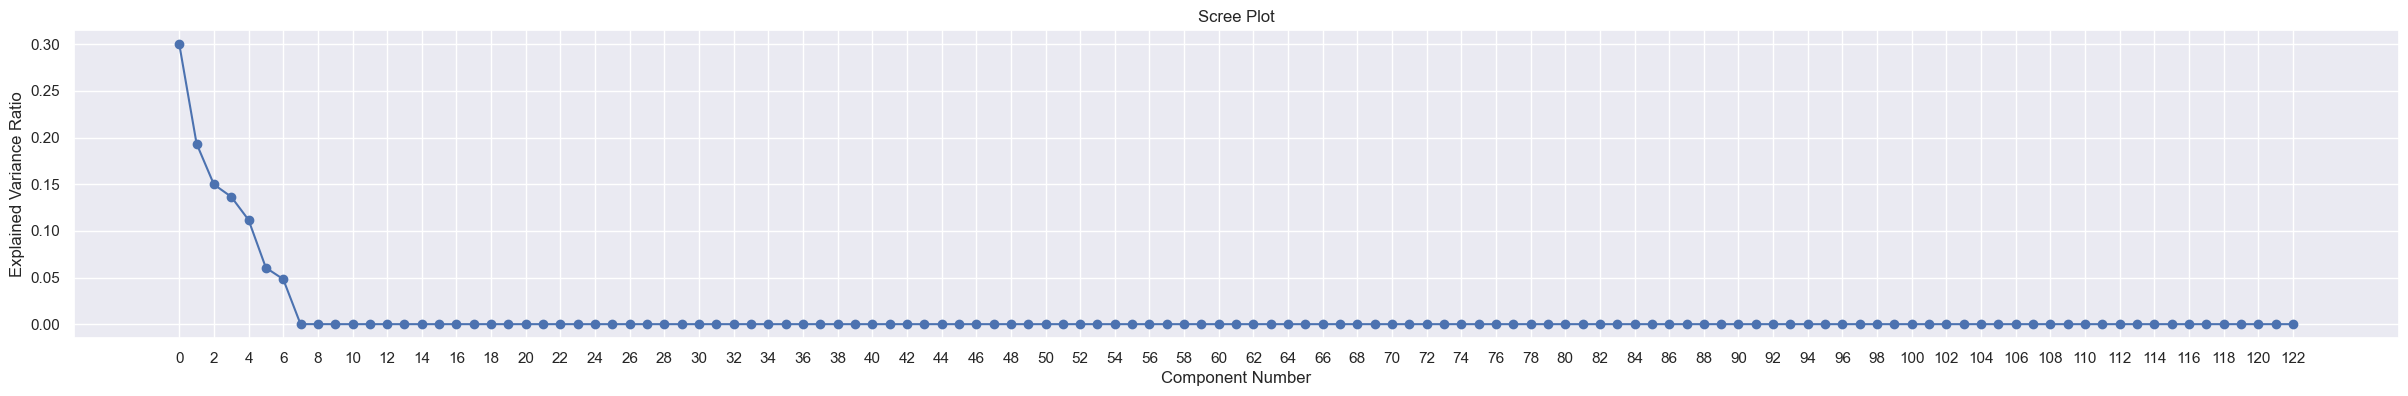

In [34]:
pca = PCA()
Xa_pca = pca.fit_transform(Xa)

explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_  

sns.set(rc={'figure.figsize':(30,4)})
plt.plot(explained_variance_ratio, marker='o')
plt.xticks(range(len(explained_variance_ratio))[::2])
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

Multiple inflection points were observed between 0-6 before it reaches a flat line.

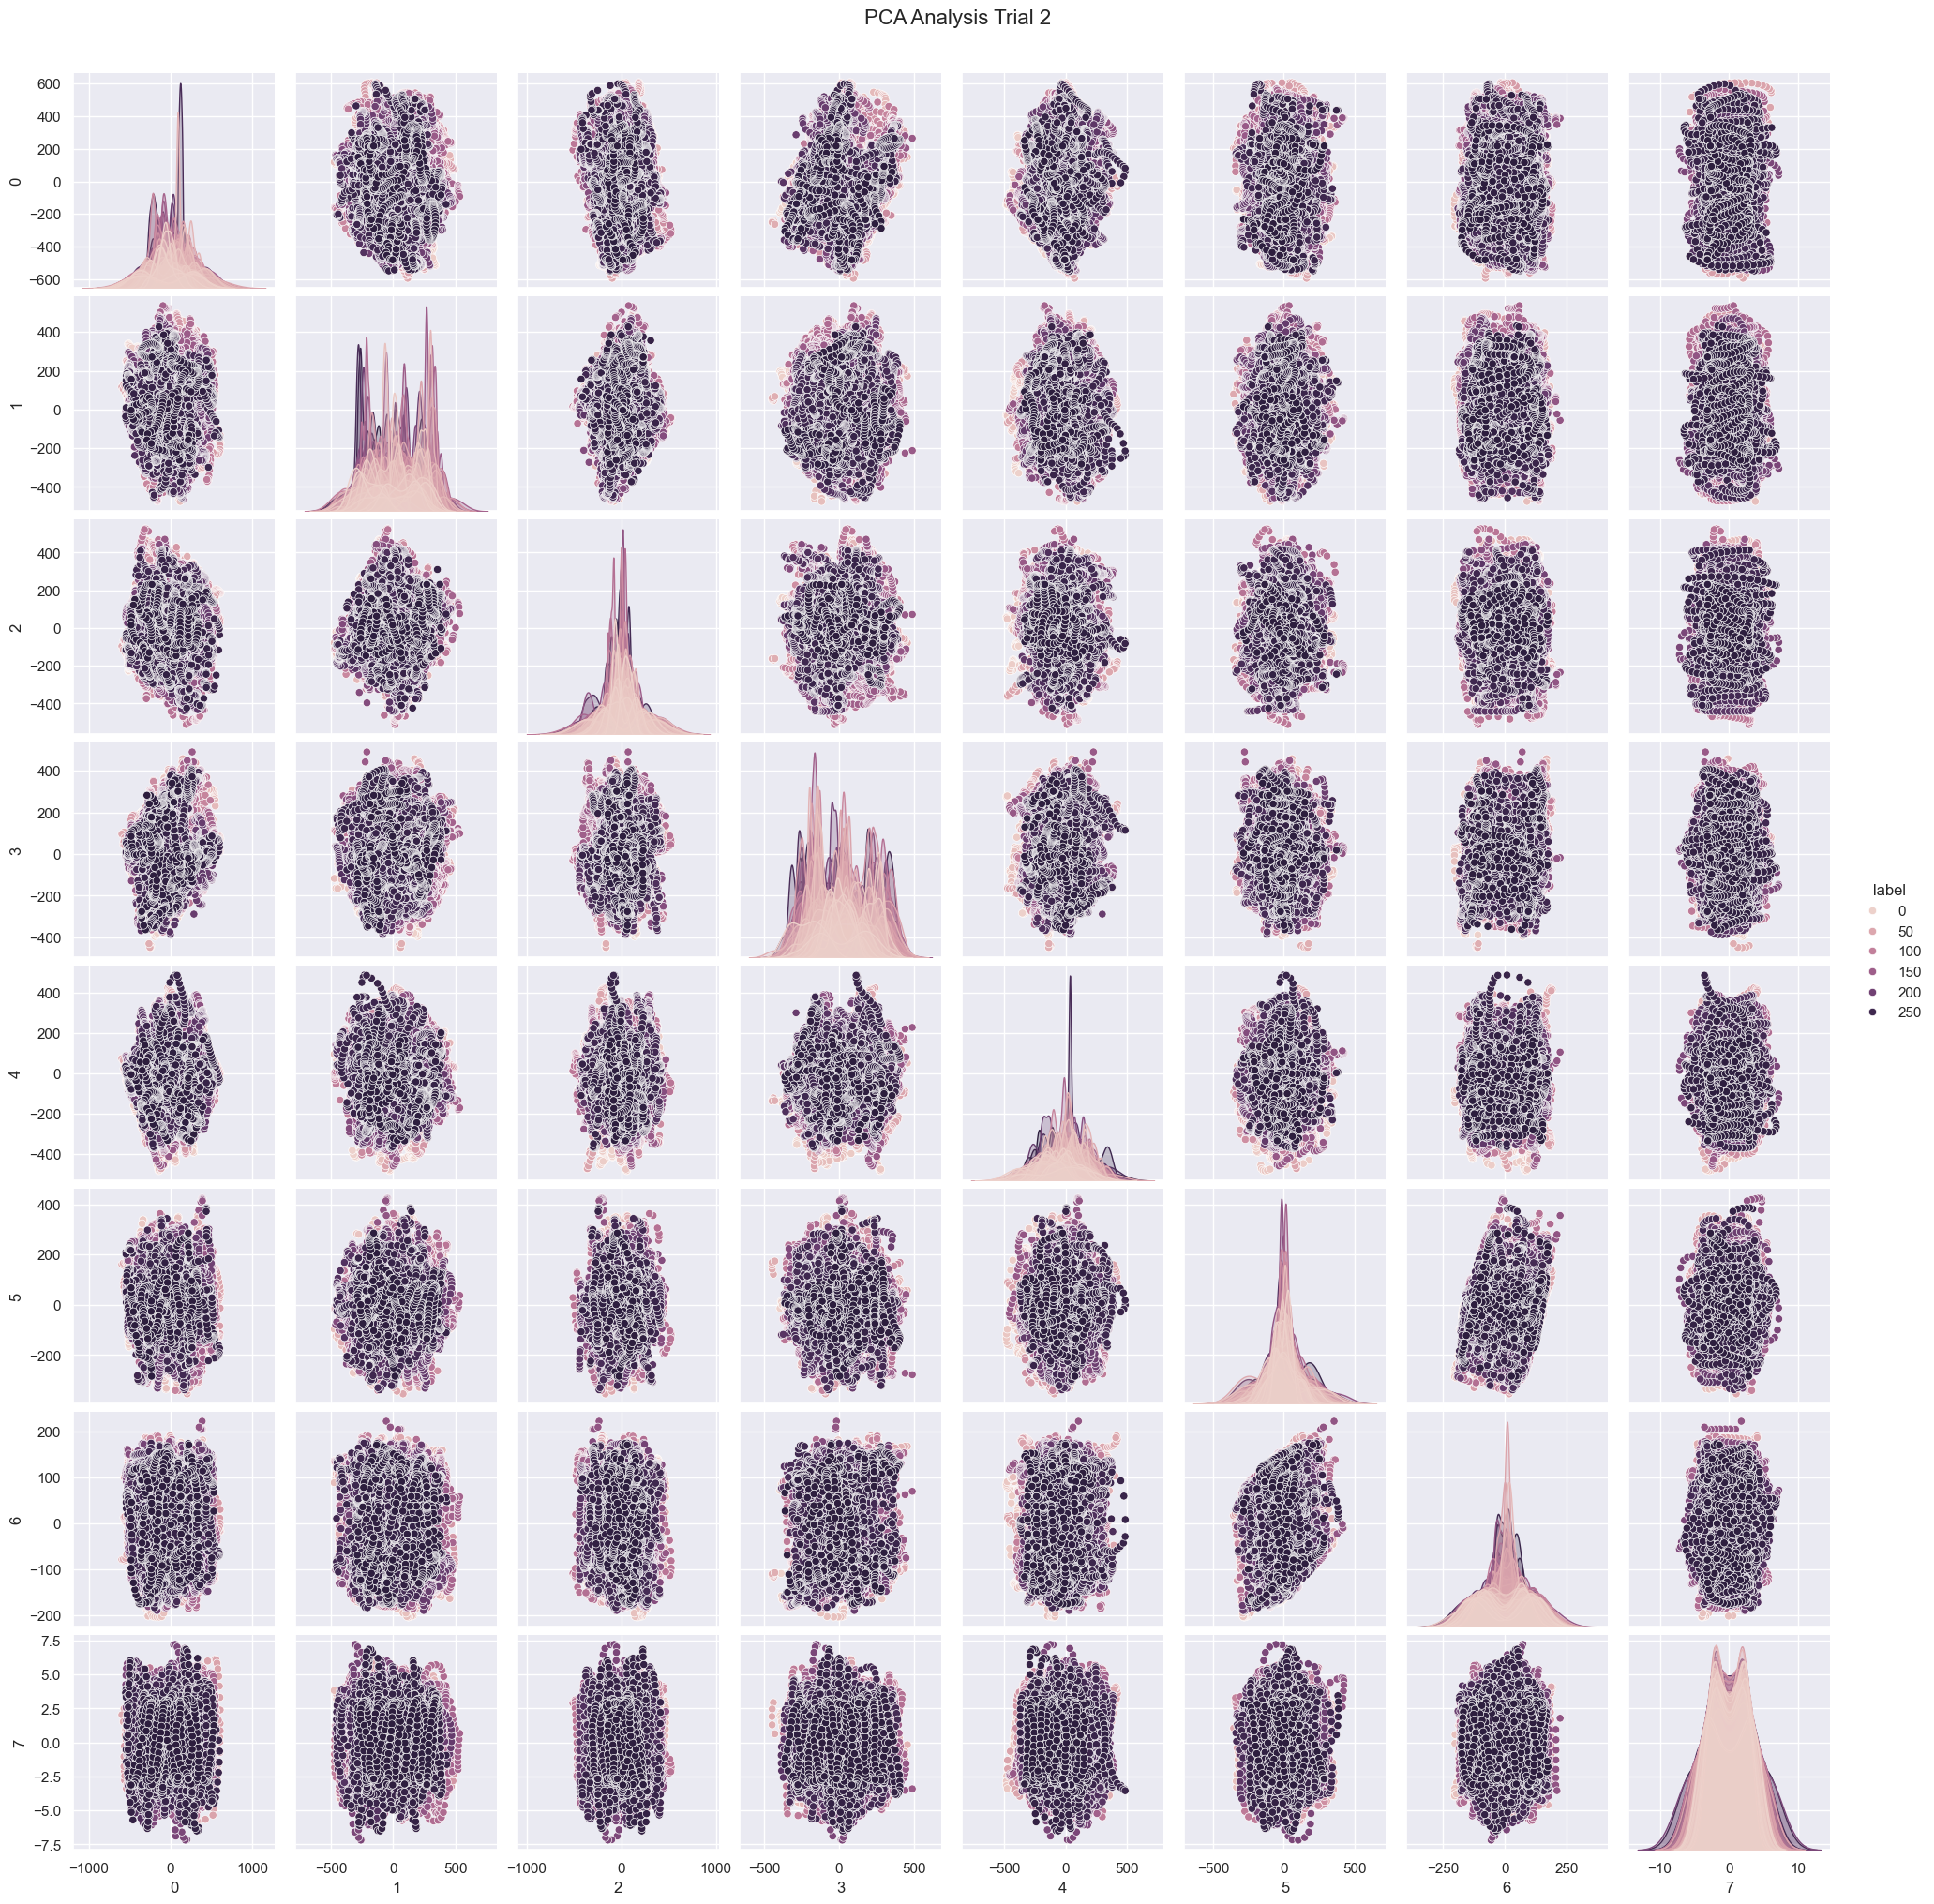

In [15]:
pca = PCA(n_components=8)
Xa_pca = pca.fit_transform(Xa)
pca_res = pd.DataFrame(data = Xa_pca)
pca_res['label'] = ya

pairplot_fig = sns.pairplot(pca_res, hue='label')
pairplot_fig.fig.suptitle('PCA Analysis Trial 2', size=16, y=1.02)
pairplot_fig.savefig("trial2_feature_validation_pca_pairplot.png")
plt.show()

### 4.2.2 Linear Discriminant Analysis

LDA technique is employed to extract insights into class separability.

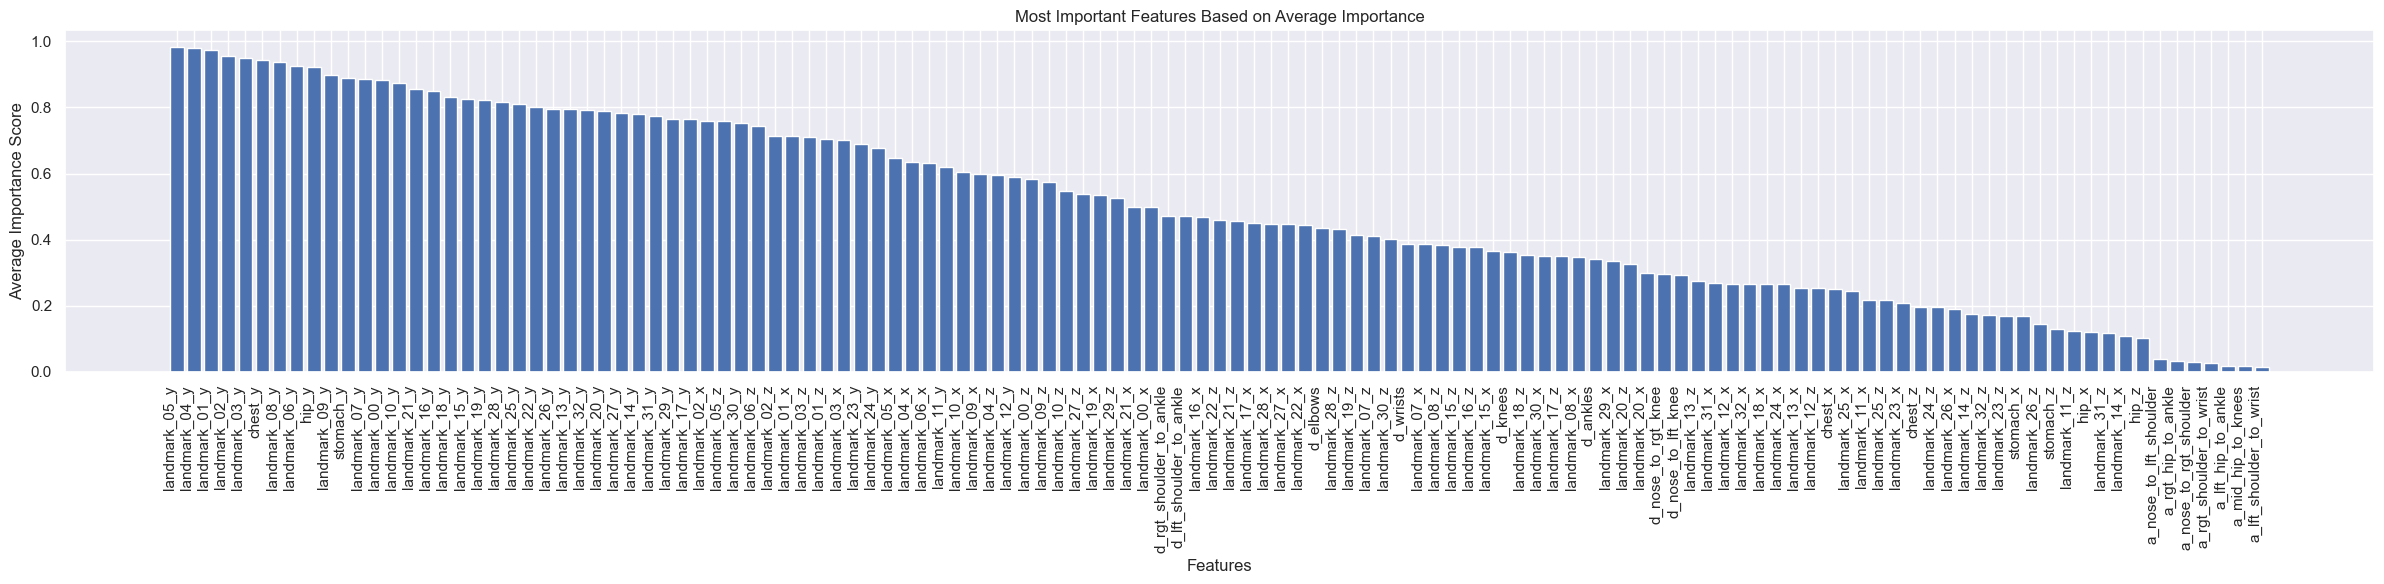

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(Xa, ya)
features = Xa.columns

total_features = len(Xa.columns)

# Calculate importance score based on position in the sorted list
feature_importances = {}
for i in range(lda.coef_.shape[0]):
  sorted_coef_indices = np.argsort(np.abs(lda.coef_[i]))[::-1]
  for j, idx in enumerate(sorted_coef_indices):
    feature = features[idx]
      
    # Importance score based on position (higher position gets higher score)
    score = 1 - (j / (total_features - 1))
    feature_importances[feature] = feature_importances.get(feature, 0) + score

# Sort features and importance scores by average importance
sorted_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
features = list(sorted_importances.keys())
average_importances = [sorted_importances[f] / len(lda.coef_) for f in features]  # Average importance across classes

plt.figure(figsize=(24, 6))
plt.bar(features, average_importances)
plt.xlabel("Features")
plt.ylabel("Average Importance Score")
plt.title("Most Important Features Based on Average Importance")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.3 KNN Classification Prediction

### 4.3.1 PCA-Reduced Training and Test Split

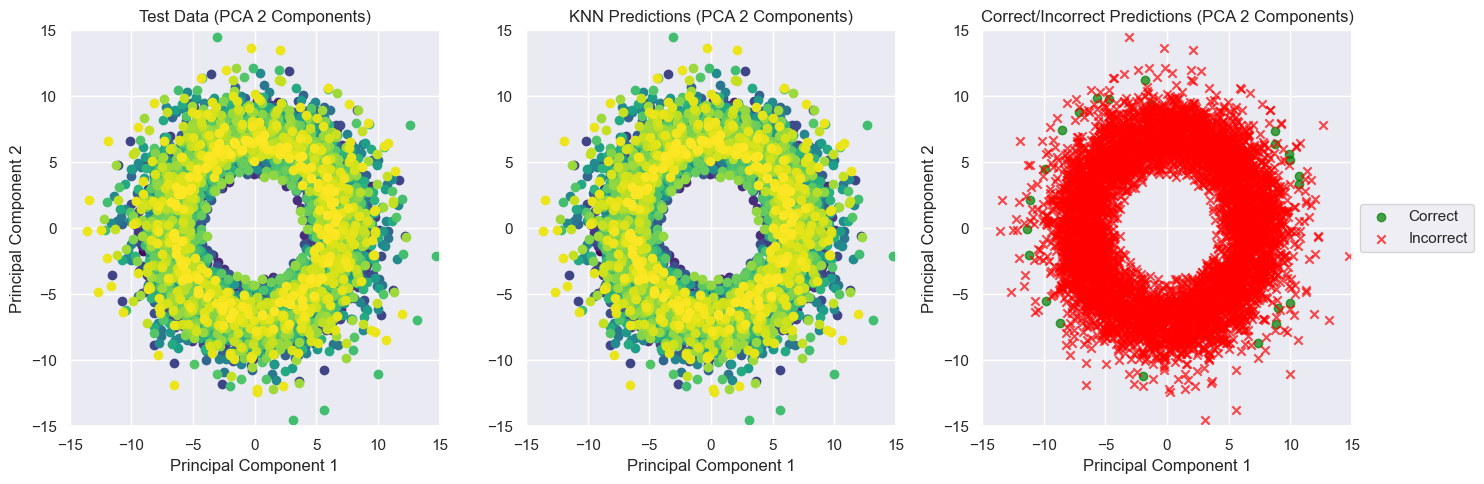

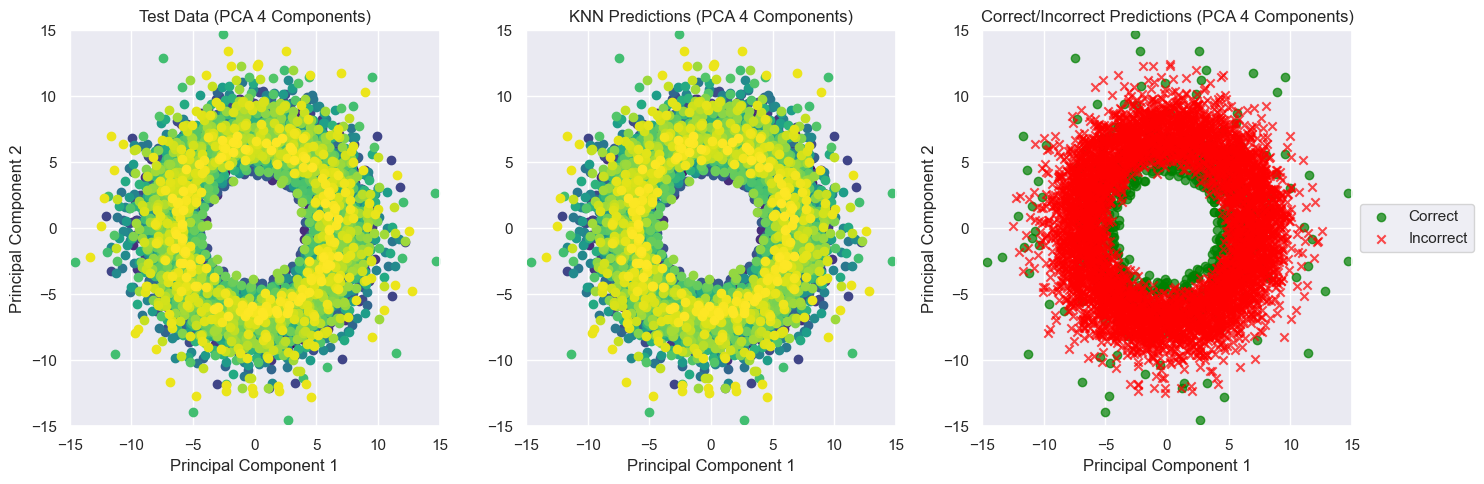

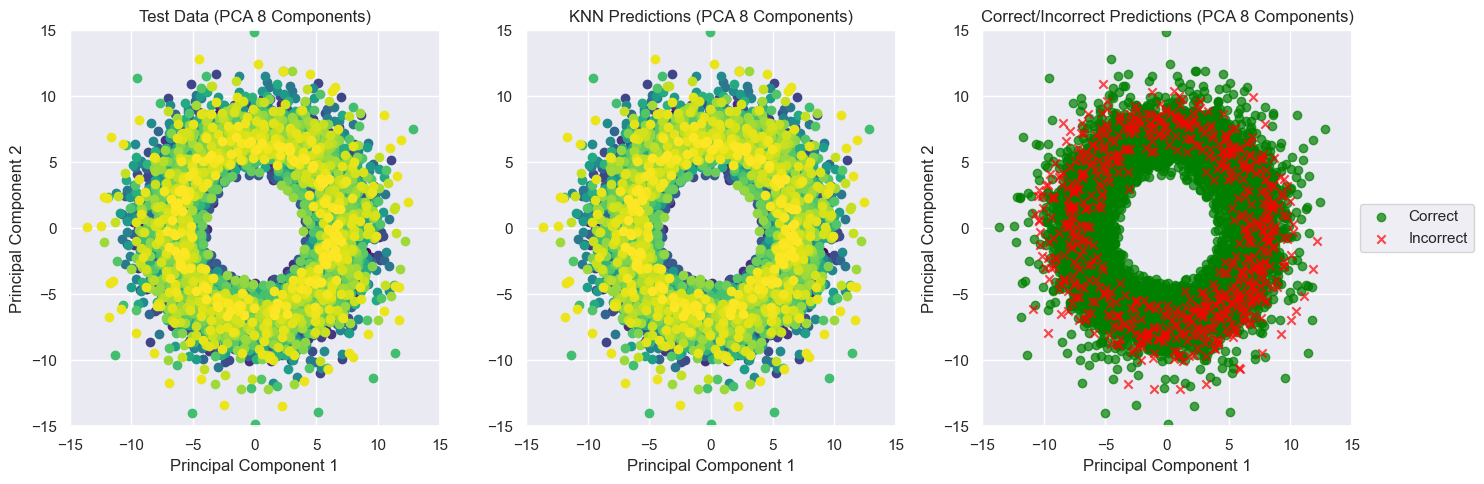

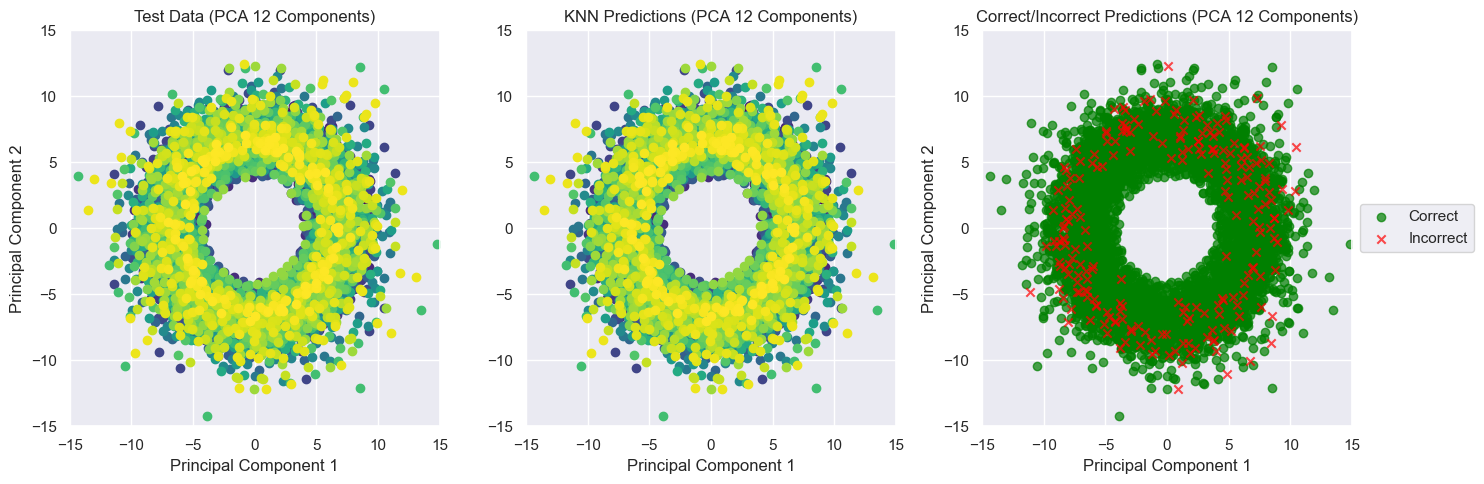

In [65]:
from helpers.pca_pipelines import pca_reduced_knn_training_validation

accuracy1, precision1, recall1, f11, conf_matrix1 = pca_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=2, test_size=0.3)

accuracy2, precision2, recall2, f12, conf_matrix2 = pca_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=4, test_size=0.3)

accuracy3, precision3, recall3, f13, conf_matrix3 = pca_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=8, test_size=0.3)

accuracy4, precision4, recall4, f14, conf_matrix4 = pca_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=12, test_size=0.3)

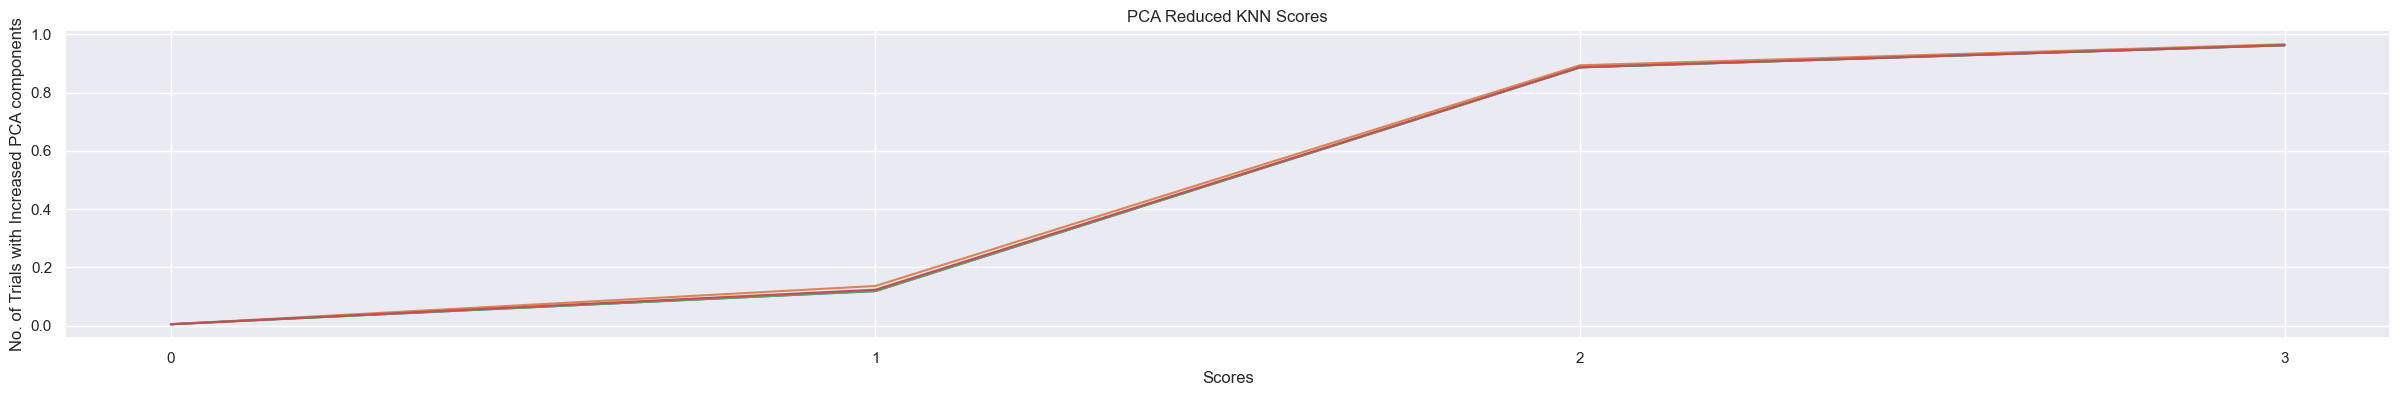

In [66]:
accuracy = [accuracy1,accuracy2,accuracy3,accuracy4]
precision = [precision1,precision2,precision3,precision4]
recall = [recall1,recall2,recall3,recall4]
f1 = [f11,f12,f13,f14]

sns.set(rc={'figure.figsize':(30,4)})
plt.plot(accuracy)
plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.xticks(range(len(accuracy))[::1])
plt.title("PCA Reduced KNN Scores")
plt.xlabel("Scores")
plt.ylabel("No. of Trials with Increased PCA components")
plt.grid(True)
plt.show()

In [67]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: [0.004765146358066712, 0.11844792375765827, 0.8863172226004085, 0.962219196732471]
Precision: [0.004667207792207792, 0.13602769108731871, 0.8936752343259335, 0.9658670805921938]
Recall: [0.004774637127578304, 0.1185064935064935, 0.8865784950343774, 0.9622326203208557]
F1 Score: [0.004638768232518233, 0.12324977520940733, 0.8871175020368727, 0.9626916696452429]


In [68]:
print(f"Accuracy: {accuracy3}")
print(f"Precision: {precision3}")
print(f"Recall: {recall3}")
print(f"F1 Score: {f13}")

Accuracy: 0.8863172226004085
Precision: 0.8936752343259335
Recall: 0.8865784950343774
F1 Score: 0.8871175020368727


### 4.3.2 LDA-Reduced Training and Test Split

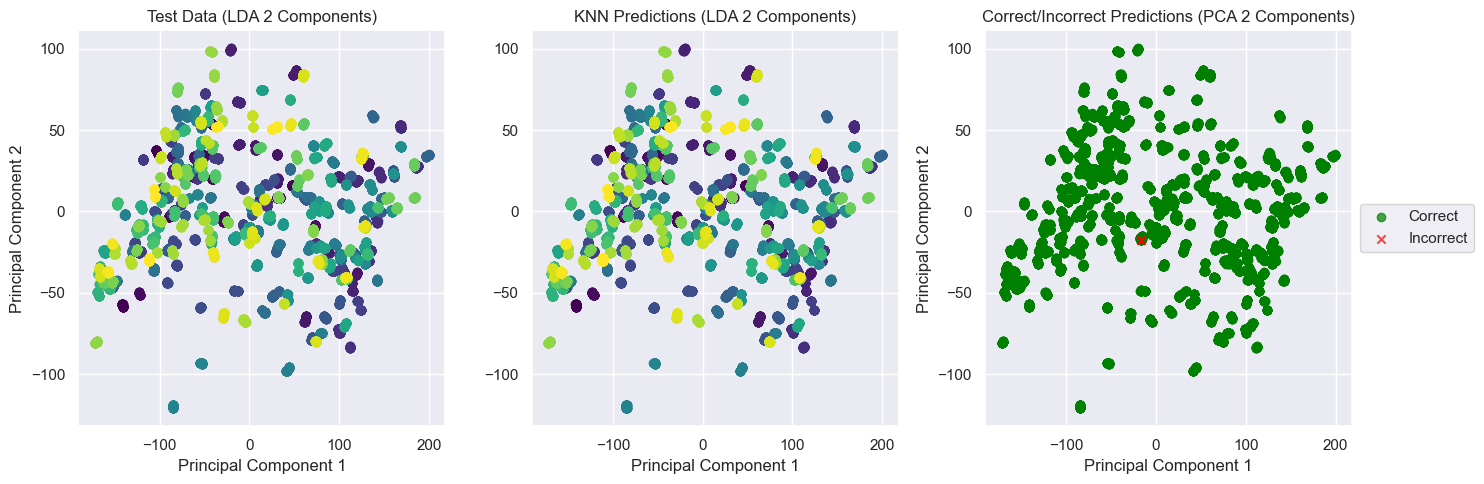

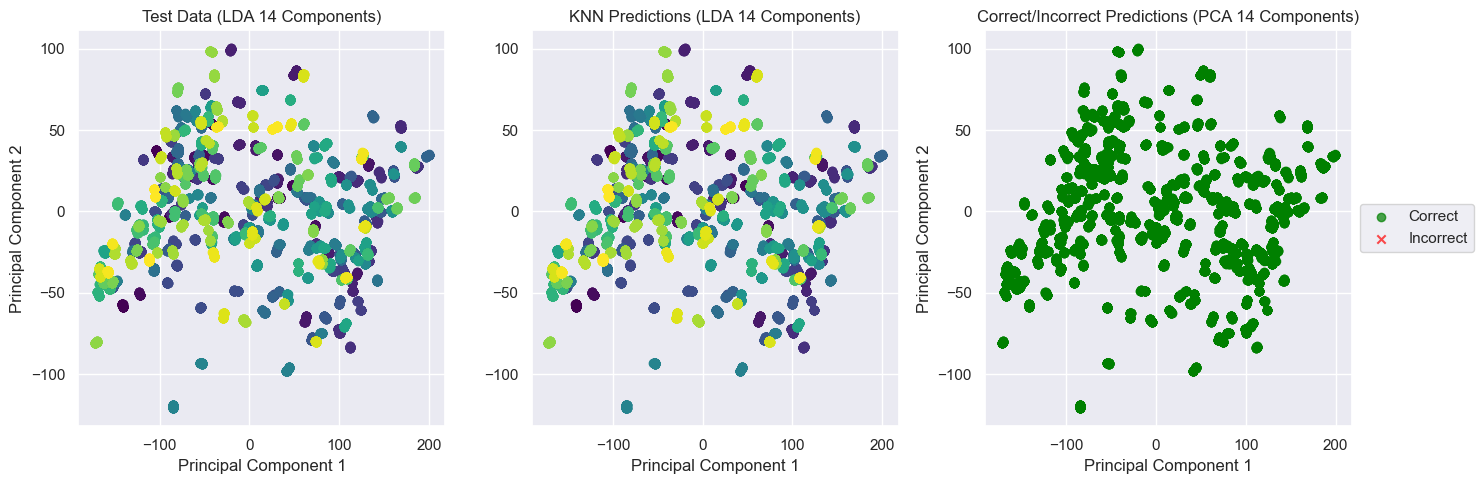

In [85]:
def lda_reduced_knn_training_validation(X,y,poses_names,n_neighbors=1, n_components=1, test_size=0.3):
    unique_poses = np.unique(poses_names)
    color_values = cm.viridis(np.linspace(0, 1, num=len(unique_poses)))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, pose_names_train, pose_names_test = train_test_split(
        X_scaled, y, poses_names, stratify=y, test_size=test_size, random_state=42)
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train,y_train)
    X_test_lda = lda.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    model.fit(X_train_lda, y_train)

    y_pred = model.predict(X_test_lda)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[0].scatter(X_test_lda[idx, 0], X_test_lda[idx, 1], color=color_values[i], label=pose)
    axes[0].set_title(f'Test Data (LDA {n_components} Components)')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    axes[0].grid(True)
    #axes[0].set_xlim([-10, 10])
    #axes[0].set_ylim([-10, 10])

    # Predictions Plot
    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[1].scatter(X_test_lda[idx, 0], X_test_lda[idx, 1], color=color_values[i], label=pose)
    axes[1].set_title(f'KNN Predictions (LDA {n_components} Components)')
    axes[1].set_xlabel('Principal Component 1')
    axes[1].grid(True)
    #axes[1].set_xlim([-10, 10])
    #axes[1].set_ylim([-10, 10])

    # True Labels Plot
    correct = y_pred == y_test
    incorrect = ~correct
    axes[2].scatter(X_test_lda[correct, 0], X_test_lda[correct, 1], c='green', marker='o', alpha=0.7, label='Correct')
    axes[2].scatter(X_test_lda[incorrect, 0], X_test_lda[incorrect, 1], c='red', marker='x', alpha=0.7, label='Incorrect')
    axes[2].set_title(f'Correct/Incorrect Predictions (PCA {n_components} Components)')
    axes[2].set_xlabel('Principal Component 1')
    axes[2].set_ylabel('Principal Component 2')
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2].grid(True)
    #axes[2].set_xlim([-10, 10])
    #axes[2].set_ylim([-10, 10])    
    
    if len(unique_poses) < 6:
        axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize='small', ncol=2)
        
    plt.tight_layout()
    plt.show()
    return accuracy, precision, recall, f1, conf_matrix

lda_reduced_knn_training_validation

accuracy1, precision1, recall1, f11, conf_matrix1 = lda_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=2, test_size=0.5)

accuracy2, precision2, recall2, f12, conf_matrix2 = lda_reduced_knn_training_validation(
    Xa_scaled,ya,poses_names,n_neighbors=1, n_components=14, test_size=0.5)

In [87]:
print("Trial 1")
print(f"Accuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1 Score: {f11}")
print("Trial 2")
print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f12}")

Trial 1
Accuracy: 0.9997957516339869
Precision: 0.9998065015479876
Recall: 0.9997957516339869
F1 Score: 0.999795593913241
Trial 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Summary

The high accuracy in KNN classification, given 272 unique classes and only 72 data points, likely signals overfitting, casting doubt on model reliability. Nonetheless, effective data reconstruction hints at potential improvement by further noise and redundancy reduction. LDA findings emphasize y-variables and head region features, unexpectedly contradicting the sport's requirements, suggesting a need for revisiting feature selection and model evaluation strategies.